<a href="https://colab.research.google.com/github/pranjal299/cv-project/blob/main/WE_MobileNet_TL_Cropped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure you have this folder as shortcut in your drive - /content/gdrive/MyDrive/Morota-video-data/ 

In [1]:
#Mount Google Drive 
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


### Data Loading

In [2]:
#@markdown Select resolution of input dataset and weeks of data

Instantiate_New_Dataset = True #@param {type:"boolean"}
Refresh_Old_Dataset = False #@param {type:"boolean"}

if Instantiate_New_Dataset == True:
  !rm -rf Week*/

Resolution = "256"  #@param ['720', '512', '256']

if Refresh_Old_Dataset == False:
  if Resolution == "720":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_720.zip .
    !unzip -qq CROPPED_WEEK1-10_720.zip -d .
    !rm -rf *WEEK*.zip

  if Resolution == "512":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_512.zip .
    !unzip -qq CROPPED_WEEK1-10_512.zip -d .
    !rm -rf *WEEK*.zip

  if Resolution == "256":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_256.zip .
    !unzip -qq CROPPED_WEEK1-10_256.zip -d .
    !rm -rf *WEEK*.zip

### Mapping Table Input

In [3]:
import pandas as pd

In [4]:
final_map = pd.read_csv("/content/gdrive/MyDrive/Morota-video-data/final_mapping.csv")

In [5]:
weeks = final_map

In [6]:
weeks

,image_path,Date,Pig,weight,Week
0,Week1/20210922/20210922_3330_b/_Depth_4683.jpg,20210922,3330,15.5,1
1,Week1/20210922/20210922_3330_b/_Depth_4778.jpg,20210922,3330,15.5,1
2,Week1/20210922/20210922_3330_b/_Depth_4579.jpg,20210922,3330,15.5,1
3,Week1/20210922/20210922_3330_b/_Depth_4578.jpg,20210922,3330,15.5,1
4,Week1/20210922/20210922_3330_b/_Depth_4584.jpg,20210922,3330,15.5,1
...,...,...,...,...,...
96220,Week10/20211119/20211119_3342/_Depth_3504.jpg,20211119,3342,56.6,10
96221,Week10/20211119/20211119_3342/_Depth_3318.jpg,20211119,3342,56.6,10
96222,Week10/20211119/20211119_3342/_Depth_3476.jpg,20211119,3342,56.6,10
96223,Week10/20211119/20211119_3342/_Depth_3169.jpg,20211119,3342,56.6,10


In [7]:
weeks_train = weeks[weeks["Pig"] != 3330]
#weeks_test = weeks[weeks['image_path'].str.contains('Week1/|Week2/')]

In [8]:
weeks_test = weeks[weeks["Pig"] == 3330]
#weeks_train = weeks[~weeks['image_path'].str.contains('Week1/|Week2/')]

In [9]:
image_paths_train = weeks_train['image_path'].values
labels_train = weeks_train['weight'].values
image_paths_test = weeks_test['image_path'].values
labels_test = weeks_test['weight'].values

In [10]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [11]:
input_train_dataset = tf.data.Dataset.from_tensor_slices((image_paths_train, labels_train))
input_test_dataset = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))

In [12]:
print("Number of elements in the train dataset:", tf.data.experimental.cardinality(input_train_dataset).numpy())
print("Number of elements in the test dataset:", tf.data.experimental.cardinality(input_test_dataset).numpy())

Number of elements in the train dataset: 69568
Number of elements in the test dataset: 26657


### Unaugmented




In [13]:
IMG_SIZE = int(Resolution)
channels = 1

In [14]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
#----------change gray scale and rgb----------------------------
    img = tf.image.rgb_to_grayscale(img)
#-------------------------------------------------------------------
    if int(Resolution) > IMG_SIZE:
      img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

In [18]:
batch_size = 128

train_dataset = input_train_dataset.shuffle(len(labels_train))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = input_test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

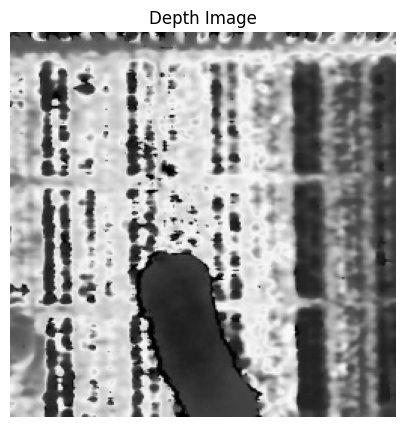

In [19]:
def visualize_sample(dataset):
    for img_batch, label_batch in dataset.take(1):
        img = img_batch[0].numpy().squeeze()

        plt.figure(figsize=(10, 5))
        plt.imshow(img, cmap='gray')
        plt.title('Depth Image')
        plt.axis('off')

        plt.show()

visualize_sample(train_dataset)

In [20]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

# Replace the create_multi_input_cnn() function with the following function
def create_transfer_learning_cnn():
    base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the pre-trained layers

    # If you are using a grayscale image, you need to duplicate the single channel to match the required input shape
    depth_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="depth_input")
    x = Concatenate()([depth_input, depth_input, depth_input])
    
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation="relu")(x)
    output = Dense(1)(x)

    model = Model(inputs=depth_input, outputs=output)
    return model

model = create_transfer_learning_cnn()
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 depth_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 3)  0           ['depth_input[0][0]',            
                                                                  'depth_input[0][0]',            
                                                                  'depth_input[0][0]']            
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 8, 8, 1280)  2257984     ['concatenate[0][0]']        

In [ ]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
544/544 [==============================] - 240s 414ms/step - loss: 62.7509 - mae: 5.6802 - mape: 19.3088 - val_loss: 57.2932 - val_mae: 5.6330 - val_mape: 15.7773
Epoch 2/50
544/544 [==============================] - 240s 441ms/step - loss: 26.8435 - mae: 3.8612 - mape: 13.3663 - val_loss: 47.7926 - val_mae: 5.0184 - val_mape: 14.0142
Epoch 3/50
544/544 [==============================] - 228s 420ms/step - loss: 21.2566 - mae: 3.4114 - mape: 11.8866 - val_loss: 46.3888 - val_mae: 4.9708 - val_mape: 13.7687
Epoch 4/50
544/544 [==============================] - 183s 336ms/step - loss: 18.6160 - mae: 3.1758 - mape: 11.0699 - val_loss: 45.9245 - val_mae: 4.8759 - val_mape: 13.4616
Epoch 5/50
 24/544 [>.............................] - ETA: 2:29 - loss: 16.9462 - mae: 3.0454 - mape: 10.7587

In [ ]:
test_loss, test_mae, test_mape = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test mean absolute error:', test_mae)
print('Test mean absolute percentage error:', test_mape)

209/209 [==============================] - 57s 272ms/step - loss: 27.3205 - mae: 3.8584 - mape: 11.0795
Test loss: 27.32050132751465
Test mean absolute error: 3.8583743572235107
Test mean absolute percentage error: 11.079508781433105
